In [1]:
import sys
!{sys.executable} -m pip install --no-deps pygooglenews==0.1.2

!{sys.executable} -m pip install dateparser

!pip install numpy pandas yfinance 

!pip install git+https://github.com/aarigs/pandas-ta.git
    
!pip install xgboost lightgbm requests pytrends

!pip install GoogleNews pytrends transformers tqdm

!pip install shap

  Cloning https://github.com/aarigs/pandas-ta.git to /tmp/pip-req-build-1u5m3dcq
  Running command git clone --filter=blob:none --quiet https://github.com/aarigs/pandas-ta.git /tmp/pip-req-build-1u5m3dcq
  Resolved https://github.com/aarigs/pandas-ta.git to commit 7a2a4210c71334929c482366d255d57eed5bdbfc
  Preparing metadata (setup.py) ... done


In [1]:
import os, glob, re, requests, time, random
import pandas as pd, numpy as np, yfinance as yf, warnings
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from pytrends.request import TrendReq
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from pytrends.request import TrendReq
from time import sleep
import pandas as pd
import numpy as np

warnings.filterwarnings('ignore')

# 설정
ROOT_DIR = "./news_data"    
START_DATE = "2020-01-01"
END_DATE = "2025-10-01"
TRAIN_END = "2024-12-31"
TICKER = "ETH-USD"
SEQ_LEN = 3
ETF_APPROVAL_DATE = "2024-01-10"  # 이더리움 ETF 승인 날짜
np.random.seed(42); tf.random.set_seed(42)

2025-10-02 22:10:56.000801: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-02 22:10:56.000840: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-02 22:10:56.002011: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-02 22:10:56.008414: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-02 22:10:56.748560: W tensorflow/comp

In [2]:
def parse_date_from_filename(filename):
    """파일명에서 날짜 추출"""
    patterns = [
        r'(\d{4})-(\d{2})-(\d{2})',
        r'(\d{4})(\d{2})(\d{2})',
        r'(\d{2})-(\d{2})-(\d{4})',
        r'(\d{2})(\d{2})(\d{4})'
    ]
    
    basename = os.path.basename(filename)
    for pattern in patterns:
        match = re.search(pattern, basename)
        if match:
            try:
                if len(match.group(1)) == 4:
                    year, month, day = match.groups()
                else:
                    day, month, year = match.groups()
                return pd.to_datetime(f"{year}-{month}-{day}")
            except:
                continue
    return None

def read_and_aggregate_news_label(folder):
    """라벨 컬럼 기반 뉴스 집계"""
    files = sorted(glob.glob(os.path.join(folder, "*.csv")))
    rows = []

    for f in files:
        try:
            df = pd.read_csv(f)
        except:
            continue
        
        if 'date' in df.columns:
            df['date'] = pd.to_datetime(df['date']).dt.normalize()
        else:
            dt = parse_date_from_filename(f)
            if dt is None:
                continue
            df['date'] = dt
        
        if 'label' in df.columns:
            df['sentiment_class'] = df['label']
        else:
            continue

        rows.append(df[['date', 'sentiment_class']])
    
    if not rows:
        return pd.DataFrame(columns=['date', 'total_news', 'pos_ratio', 'neg_ratio', 'neu_ratio'])
    
    all_df = pd.concat(rows, ignore_index=True)
    
    daily_agg = all_df.groupby('date').agg(
        total_news=('sentiment_class', 'count'),
        pos_count=('sentiment_class', lambda x: (x == 1).sum()),
        neg_count=('sentiment_class', lambda x: (x == -1).sum()),
        neu_count=('sentiment_class', lambda x: (x == 0).sum())
    ).reset_index()
    
    daily_agg['pos_ratio'] = daily_agg['pos_count'] / daily_agg['total_news']
    daily_agg['neg_ratio'] = daily_agg['neg_count'] / daily_agg['total_news']
    daily_agg['neu_ratio'] = daily_agg['neu_count'] / daily_agg['total_news']
    daily_agg['avg_sentiment'] = all_df.groupby('date')['sentiment_class'].mean().values
    
    return daily_agg[['date', 'total_news', 'pos_ratio', 'neg_ratio', 'neu_ratio','avg_sentiment']]



def fetch_price_data(start_date, end_date, ticker=TICKER):
    """가격 데이터와 거래량 데이터 가져오기"""
    df = yf.download(ticker, start=start_date, end=(pd.to_datetime(end_date)+pd.Timedelta(days=1)).strftime("%Y-%m-%d"), progress=False)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    df = df.reset_index()
    df = df.rename(columns={'Date': 'date'})
    df['date'] = pd.to_datetime(df['date']).dt.normalize()
    
    close_col = next((c for c in df.columns if 'close' in str(c).lower()), None)
    volume_col = next((c for c in df.columns if 'volume' in str(c).lower()), None)
    
    if close_col is None:
        raise RuntimeError("No close column found")
    
    df['close'] = df[close_col]
    df['volume'] = df[volume_col] if volume_col else 0
    
    return df[['date', 'close', 'volume']].copy()

In [3]:

def fetch_futures_data():
    """선물 데이터 가져오기 (CME 이더리움 선물)"""
    try:
        futures_df = yf.download("ETH=F", start=START_DATE, end=END_DATE, progress=False)
        if isinstance(futures_df.columns, pd.MultiIndex):
            futures_df.columns = futures_df.columns.get_level_values(0)
        futures_df = futures_df.reset_index()
        futures_df = futures_df.rename(columns={'Date': 'date'})
        futures_df['date'] = pd.to_datetime(futures_df['date']).dt.normalize()
        
        close_col = next((c for c in futures_df.columns if 'close' in str(c).lower()), None)
        if close_col:
            futures_df['futures_close'] = futures_df[close_col]
            return futures_df[['date', 'futures_close']].copy()
    except:
        pass
    
    return pd.DataFrame(columns=['date', 'futures_close'])

def fetch_macro_data():
    """거시경제 지표 데이터 가져오기"""
    try:
        # 10년 국채 수익률 (금리 대리변수)
        treasury = yf.download("^TNX", start=START_DATE, end=END_DATE, progress=False)
        if isinstance(treasury.columns, pd.MultiIndex):
            treasury.columns = treasury.columns.get_level_values(0)
        treasury = treasury.reset_index()
        treasury = treasury.rename(columns={'Date': 'date'})
        treasury['date'] = pd.to_datetime(treasury['date']).dt.normalize()
        
        close_col = next((c for c in treasury.columns if 'close' in str(c).lower()), None)
        if close_col:
            treasury['interest_rate'] = treasury[close_col]
            
        # 달러 지수 (DXY)
        dxy = yf.download("DX-Y.NYB", start=START_DATE, end=END_DATE, progress=False)
        if isinstance(dxy.columns, pd.MultiIndex):
            dxy.columns = dxy.columns.get_level_values(0)
        dxy = dxy.reset_index()
        dxy = dxy.rename(columns={'Date': 'date'})
        dxy['date'] = pd.to_datetime(dxy['date']).dt.normalize()
        
        close_col = next((c for c in dxy.columns if 'close' in str(c).lower()), None)
        if close_col:
            dxy['dxy'] = dxy[close_col]
        
        # 데이터 병합
        macro_df = pd.merge(treasury[['date', 'interest_rate']], 
                           dxy[['date', 'dxy']], 
                           on='date', how='outer')
        
        return macro_df
    except Exception as e:
        print(f"거시경제 데이터 수집 실패: {e}")
        return pd.DataFrame(columns=['date', 'interest_rate', 'dxy'])



def fetch_google_trends(sleep_sec=5):
    """구글 트렌드 데이터 수집"""
    try:
        pytrends = TrendReq(hl='en-US', tz=360)

        # 공백 키워드 → 언더스코어로 대체 (Google Trends는 URL 인코딩되므로 공백 안전하게 처리)
        keyword_groups = [
            ['ethereum', 'eth', 'ether','bitcoin'],
            ['ethereum_etf', 'defi', 'smart_contract']
        ]

        all_trends = []

        for keywords in keyword_groups:
            # Google Trends는 최대 5개의 키워드만 허용
            pytrends.build_payload(keywords, cat=0, timeframe=f'{START_DATE} {END_DATE}', geo='', gprop='')
            trends_df = pytrends.interest_over_time()
            sleep(random.uniform(sleep_sec, sleep_sec + 2))  

            if trends_df.empty:
                continue

            trends_df = trends_df.reset_index()
            trends_df['date'] = pd.to_datetime(trends_df['date']).dt.normalize()

            for kw in keywords:
                col_name = f"{kw}_trend"
                if kw in trends_df.columns:
                    trends_df[col_name] = trends_df[kw]
                else:
                    trends_df[col_name] = 0

            all_trends.append(trends_df[['date'] + [f"{kw}_trend" for kw in keywords]])

        if not all_trends:
            raise ValueError("모든 트렌드 요청이 실패했습니다.")

        # 날짜 기준으로 병합
        final_trend_df = all_trends[0]
        for other in all_trends[1:]:
            final_trend_df = pd.merge(final_trend_df, other, on='date', how='outer')

        # 총합 트렌드
        trend_cols = [col for col in final_trend_df.columns if col.endswith('_trend')]
        final_trend_df['total_trend'] = final_trend_df[trend_cols].sum(axis=1)

        return final_trend_df[['date'] + trend_cols + ['total_trend']].fillna(0)

    except Exception as e:
        print(f"구글 트렌드 데이터 수집 실패: {e}")

        # 예외 발생 시 더미 데이터 생성
        date_range = pd.date_range(start=START_DATE, end=END_DATE, freq='D')
        dummy = {
            'date': date_range
        }
        trend_cols = ['ethereum_trend', 'eth_trend', 'ether_trend',
                      'ethereum_etf_trend', 'defi_trend', 'smart_contract_trend']

        for col in trend_cols:
            dummy[col] = np.random.randint(0, 100, len(date_range))

        dummy['total_trend'] = np.random.randint(0, 300, len(date_range))

        df_dummy = pd.DataFrame(dummy)
        print("더미 트렌드 데이터 (샘플):")
        print(df_dummy.head())

        return df_dummy


def add_technical_indicators(df):
    """기술적 지표 추가"""
    df['SMA_12'] = df['close'].rolling(window=12).mean()
    df['SMA_26'] = df['close'].rolling(window=26).mean()

    delta = df['close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    ema_12 = df['close'].ewm(span=12, adjust=False).mean()
    ema_26 = df['close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = ema_12 - ema_26
    df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    
    df['SMA_cross'] = (df['SMA_12'] > df['SMA_26']).astype(int)
    df['MACD_hist'] = df['MACD'] - df['MACD_signal']
    df['RSI_over'] = np.where(df['RSI'] > 70, 1, np.where(df['RSI'] < 30, -1, 0))
    
    # 거래량 기반 지표 추가
    if 'volume' in df.columns:
        df['volume_sma'] = df['volume'].rolling(window=20).mean()
        df['volume_ratio'] = df['volume'] / df['volume_sma']
        df['price_volume'] = df['close'] * df['volume']
    
    return df


In [4]:

def make_lstm_dataset(X, y, seq_len):
    X_seq, y_seq = [], []
    for i in range(seq_len, len(X)):
        X_seq.append(X[i-seq_len:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

def build_lstm_model(input_dim, units=50):
    model = Sequential([
        LSTM(units, input_shape=(SEQ_LEN, input_dim)),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
    return model

def compute_metrics(y_true, y_pred, y_prob=None):
    mask = ~pd.isna(y_pred)
    if mask.sum() == 0:
        return {'Accuracy': np.nan, 'Precision': np.nan, 'Recall': np.nan, 'F1': np.nan, 'AUC': np.nan}
    
    y_t = y_true[mask].astype(int)
    y_p = y_pred[mask].astype(int)
    
    metrics = {
        'Accuracy': accuracy_score(y_t, y_p),
        'Precision': precision_score(y_t, y_p, zero_division=0),
        'Recall': recall_score(y_t, y_p, zero_division=0),
        'F1': f1_score(y_t, y_p, zero_division=0)
    }
    
    if y_prob is not None and len(np.unique(y_t)) > 1:
        metrics['AUC'] = roc_auc_score(y_t, y_prob[mask])
    else:
        metrics['AUC'] = np.nan
    
    return metrics

def train_models(X_train, X_test, y_train, y_test, model_prefix):
    results = []
    
    # 로지스틱 회귀
    logit = LogisticRegression(max_iter=2000, random_state=42)
    logit.fit(X_train, y_train)
    pred_logit = logit.predict(X_test)
    prob_logit = logit.predict_proba(X_test)[:, 1]
    results.append({'Model': f'{model_prefix}_Logit', **compute_metrics(y_test, pred_logit, prob_logit)})
    
    # 인공신경망
    ann = MLPClassifier(hidden_layer_sizes=(20, 10), max_iter=2000, random_state=42)
    ann.fit(X_train, y_train)
    pred_ann = ann.predict(X_test)
    prob_ann = ann.predict_proba(X_test)[:, 1]
    results.append({'Model': f'{model_prefix}_ANN', **compute_metrics(y_test, pred_ann, prob_ann)})
    
    # SVM
    svm = SVC(kernel='rbf', probability=True, random_state=42)
    svm.fit(X_train, y_train)
    pred_svm = svm.predict(X_test)
    prob_svm = svm.predict_proba(X_test)[:, 1]
    results.append({'Model': f'{model_prefix}_SVM', **compute_metrics(y_test, pred_svm, prob_svm)})
    
    return results

def train_lstm_model(X_train, X_test, y_train, y_test, model_name, seq_len=SEQ_LEN):
    if len(X_train) < seq_len:
        return {'Model': model_name, 'Accuracy': np.nan, 'Note': 'Insufficient data for LSTM'}
    
    X_train_seq, y_train_seq = make_lstm_dataset(X_train, y_train, seq_len)
    X_test_seq, y_test_seq = make_lstm_dataset(X_test, y_test, seq_len)

    if len(X_train_seq) == 0 or len(X_test_seq) == 0:
        return {'Model': model_name, 'Accuracy': np.nan, 'Note': 'No sequences generated'}
    
    model = build_lstm_model(X_train_seq.shape[2])
    model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=32, verbose=0)
    
    prob_lstm = model.predict(X_test_seq, verbose=0)[:, 0]
    pred_lstm = (prob_lstm > 0.5).astype(int)
    
    return {'Model': model_name, **compute_metrics(y_test_seq, pred_lstm, prob_lstm)}


In [5]:


# 1. 기본 데이터 수집
print("\n[1단계] 기본 데이터 수집 중...")
news_data = read_and_aggregate_news_label(ROOT_DIR)
news_data = news_data[(news_data['date'] >= pd.to_datetime(START_DATE)) & 
                     (news_data['date'] <= pd.to_datetime(END_DATE))].reset_index(drop=True)

price_data = fetch_price_data(START_DATE, END_DATE, TICKER)
price_data = price_data[price_data['date'] >= pd.to_datetime(START_DATE)].reset_index(drop=True)
price_data = add_technical_indicators(price_data)

# 추가 데이터 수집
print("\n[2단계] 추가 데이터 수집 중...")
macro_data = fetch_macro_data()
futures_data = fetch_futures_data()
trends_data = fetch_google_trends()

# 비트코인 가격 수집
btc_data = fetch_price_data(START_DATE, END_DATE, "BTC-USD")
btc_data = btc_data[['date', 'close']].rename(columns={'close': 'btc_close'})
btc_data['btc_return'] = btc_data['btc_close'].pct_change()
for lag in [1, 2, 3]:
    btc_data[f'btc_return_lag_{lag}'] = btc_data['btc_return'].shift(lag)

# bitcoin_trend 누락 방지
if 'bitcoin_trend' not in trends_data.columns:
    trends_data['bitcoin_trend'] = 0

# 트렌드 파생 피처 생성
trends_data['total_trend_ma7'] = trends_data['total_trend'].rolling(window=7).mean()
trends_data['total_trend_diff'] = trends_data['total_trend'].diff()


print(f"뉴스 데이터: {news_data.shape[0]}개")
print(f"가격 데이터: {price_data.shape[0]}개")
print(f"거시경제 데이터: {macro_data.shape[0]}개")
print(f"선물 데이터: {futures_data.shape[0]}개") 
print(f"트렌드 데이터: {trends_data.shape[0]}개")

# 3. 데이터 병합 및 전처리
print("\n[3단계] 데이터 병합 및 전처리...")
df = pd.merge(price_data, news_data, on='date', how='left').sort_values('date').reset_index(drop=True)

# 뉴스 없는 날은 0으로 채움
news_cols = ['total_news', 'pos_ratio', 'neg_ratio', 'neu_ratio', 'avg_sentiment']
df[news_cols] = df[news_cols].fillna(0)

# 거시경제 데이터 병합
if not macro_data.empty:
    df = pd.merge(df, macro_data, on='date', how='left')
    df[['interest_rate', 'dxy']] = df[['interest_rate', 'dxy']].fillna(method='ffill')

# 선물 데이터 병합
if not futures_data.empty:
    df = pd.merge(df, futures_data, on='date', how='left')
    df['futures_close'] = df['futures_close'].fillna(method='ffill')

# 구글 트렌드 데이터 병합
df = pd.merge(df, trends_data, on='date', how='left')
trend_cols = ['ethereum_trend', 'eth_trend', 'ether_trend', 
              'ethereum_etf_trend', 'defi_trend', 'smart_contract_trend', 'bitcoin_trend']

df[trend_cols] = df[trend_cols].fillna(0)


# BTC 가격 병합
df = pd.merge(df, btc_data, on='date', how='left')

print("데이터 수집 완료")


[1단계] 기본 데이터 수집 중...

[2단계] 추가 데이터 수집 중...
구글 트렌드 데이터 수집 실패: The request failed: Google returned a response with code 429
더미 트렌드 데이터 (샘플):
        date  ethereum_trend  eth_trend  ether_trend  ethereum_etf_trend  \
0 2020-01-01              51         75           80                  82   
1 2020-01-02              92         48           99                  94   
2 2020-01-03              14         93           13                  52   
3 2020-01-04              71         84            9                  31   
4 2020-01-05              60         30           34                  65   

   defi_trend  smart_contract_trend  total_trend  
0          98                    63           24  
1          22                    89           56  
2          80                    85           31  
3           0                    61           11  
4          78                    71           91  
뉴스 데이터: 2059개
가격 데이터: 2101개
거시경제 데이터: 1446개
선물 데이터: 1171개
트렌드 데이터: 2101개

[3단계] 데이터 병합 및 전처리...
데

In [6]:

# 타겟 생성 및 피쳐 엔지니어링
df['return'] = df['close'].pct_change()
threshold = 0.005
df['target'] = np.where(df['return'] > threshold, 1, np.where(df['return'] < -threshold, 0, np.nan))

# ETF 승인 이후 가중치
etf_date = pd.to_datetime(ETF_APPROVAL_DATE)
df['post_etf'] = (df['date'] >= etf_date).astype(int)

# 시차 피쳐 생성
for lag in [1, 2, 3]:
    df[f'return_lag_{lag}'] = df['return'].shift(lag)
    df[f'pos_ratio_lag_{lag}'] = df['pos_ratio'].shift(lag)
    df[f'neg_ratio_lag_{lag}'] = df['neg_ratio'].shift(lag)
    df[f'avg_sentiment_lag_{lag}'] = df['avg_sentiment'].shift(lag)
    
    if not macro_data.empty:
        df[f'interest_rate_lag_{lag}'] = df['interest_rate'].shift(lag)
        df[f'dxy_lag_{lag}'] = df['dxy'].shift(lag)
    
    if not futures_data.empty:
        df[f'futures_return_lag_{lag}'] = df['futures_close'].pct_change().shift(lag)
    
    for col in trend_cols:
        df[f'{col}_lag_{lag}'] = df[col].shift(lag)

        
# 트렌드 파생 lag 피처
df['total_trend_ma7'] = df['total_trend_ma7']
df['total_trend_diff'] = df['total_trend_diff']        
df['total_trend_lag_1'] = df['total_trend'].shift(1)       
        
# 상호작용 피처
df['pos_x_ret'] = df['pos_ratio_lag_1'] * df['return_lag_1']
df['neg_x_ret'] = df['neg_ratio_lag_1'] * df['return_lag_1']
df['sentiment_x_ret'] = df['avg_sentiment_lag_1'] * df['return_lag_1']
df['total_news_lag_1'] = df['total_news'].shift(1)
df['sentiment_x_volume'] = df['avg_sentiment_lag_1'] * df['total_news_lag_1']
if 'volume_ratio' in df.columns:
    df['sentiment_x_vol_ratio'] = df['avg_sentiment_lag_1'] * df['volume_ratio']

# 피처 그룹 정의
base_price_features = ['return_lag_1', 'return_lag_2', 'return_lag_3', 'SMA_12', 'SMA_26', 
                       'RSI', 'MACD', 'MACD_signal', 'SMA_cross', 'MACD_hist', 'RSI_over']

news_features = ['pos_ratio_lag_1', 'neg_ratio_lag_1', 'avg_sentiment_lag_1']

volume_features = []
if 'volume_ratio' in df.columns:
    volume_features = ['volume_ratio', 'price_volume']

macro_features = []
if not macro_data.empty:
    macro_features = ['interest_rate_lag_1', 'dxy_lag_1', 'post_etf']

futures_features = []
if not futures_data.empty:
    futures_features = ['futures_return_lag_1']

trend_features = ['ethereum_trend_lag_1', 'bitcoin_trend_lag_1', 'total_trend_lag_1', 
                  'total_trend_ma7', 'total_trend_diff']

external_features = ['btc_return_lag_1', 'btc_return_lag_2', 'btc_return_lag_3']

interaction_features = ['pos_x_ret', 'neg_x_ret', 'sentiment_x_ret', 'sentiment_x_volume']
if 'sentiment_x_vol_ratio' in df.columns:
    interaction_features.append('sentiment_x_vol_ratio')

# 전체 피처
all_features = (
    base_price_features + news_features + volume_features +
    macro_features + futures_features + trend_features +
    external_features + interaction_features
)


In [7]:
missing_features = [f for f in all_features if f not in df.columns]
print("누락된 피처:", missing_features)
print(df[all_features + ['target']].isna().sum())


누락된 피처: []
return_lag_1               2
return_lag_2               3
return_lag_3               4
SMA_12                    11
SMA_26                    25
RSI                       13
MACD                       0
MACD_signal                0
SMA_cross                  0
MACD_hist                  0
RSI_over                   0
pos_ratio_lag_1            1
neg_ratio_lag_1            1
avg_sentiment_lag_1        1
volume_ratio              19
price_volume               0
interest_rate_lag_1        2
dxy_lag_1                  2
post_etf                   0
futures_return_lag_1     403
ethereum_trend_lag_1       1
bitcoin_trend_lag_1        1
total_trend_lag_1          1
total_trend_ma7            6
total_trend_diff           1
btc_return_lag_1           2
btc_return_lag_2           3
btc_return_lag_3           4
pos_x_ret                  2
neg_x_ret                  2
sentiment_x_ret            2
sentiment_x_volume         1
sentiment_x_vol_ratio     19
target                   316
dty

[확장 Granger 인과성 분석 - 전체]
       뉴스 감성     RSI    MACD  구글 트렌드      금리     DXY  선물 수익률  BTC 수익률
Lag 1    0.0  0.0946  0.0180  0.5285  0.6686  0.9292  0.0114   0.3863
Lag 2    0.0  0.0681  0.0054  0.4741  0.6468  0.0000  0.0000   0.0000
Lag 3    0.0  0.0377  0.1884  0.0238  0.5506  0.0000  0.0000   0.0000
Lag 4    0.0  0.0389  0.2249  0.0353  0.7084  0.0000  0.0000   0.0000
Lag 5    0.0  0.0308  0.1628  0.0687  0.8185  0.0000  0.0000   0.0000

[Granger 분석 - ETF 승인 이전]
        뉴스 감성     RSI    MACD  구글 트렌드      금리     DXY  선물 수익률  BTC 수익률
Lag 1  0.0000  0.2534  0.1797  0.5630  0.7525  0.4965  0.0542   0.7098
Lag 2  0.0000  0.1459  0.0067  0.1799  0.5374  0.0000  0.0000   0.0000
Lag 3  0.0011  0.2265  0.3083  0.0592  0.3680  0.0000  0.0000   0.0000
Lag 4  0.0010  0.2592  0.3848  0.1013  0.4722  0.0000  0.0000   0.0000
Lag 5  0.0006  0.1525  0.3098  0.1528  0.5983  0.0000  0.0000   0.0000

[Granger 분석 - ETF 승인 이후]
        뉴스 감성     RSI    MACD  구글 트렌드      금리     DXY  선물 수익률  BTC 수익률
Lag 1 

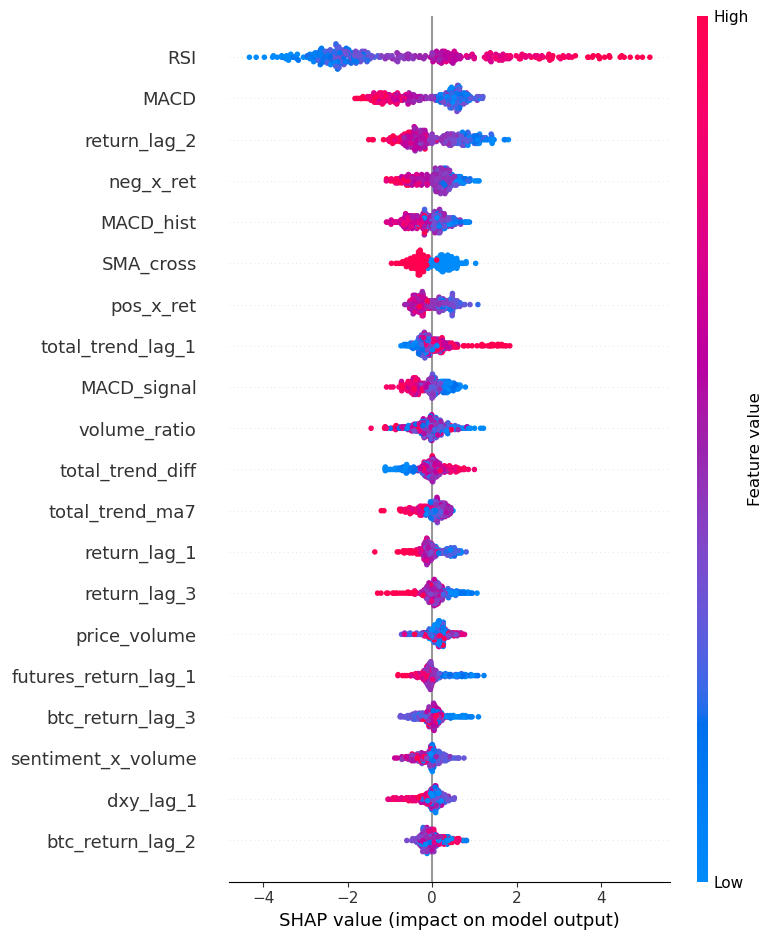


[SHAP 피처 중요도 - 텍스트 출력]
              Feature  Mean |SHAP|
                  RSI     1.886129
                 MACD     0.712106
         return_lag_2     0.575692
            neg_x_ret     0.384744
            MACD_hist     0.329219
            SMA_cross     0.323865
            pos_x_ret     0.306237
    total_trend_lag_1     0.302098
          MACD_signal     0.294580
         volume_ratio     0.277950
     total_trend_diff     0.263421
      total_trend_ma7     0.227693
         return_lag_1     0.227083
         return_lag_3     0.225030
         price_volume     0.207530
 futures_return_lag_1     0.202362
     btc_return_lag_3     0.198649
   sentiment_x_volume     0.196684
            dxy_lag_1     0.194111
     btc_return_lag_2     0.193415
     btc_return_lag_1     0.183451
 ethereum_trend_lag_1     0.175334
      pos_ratio_lag_1     0.117811
               SMA_12     0.111737
      neg_ratio_lag_1     0.109226
               SMA_26     0.108400
      sentiment_x_ret     0.105

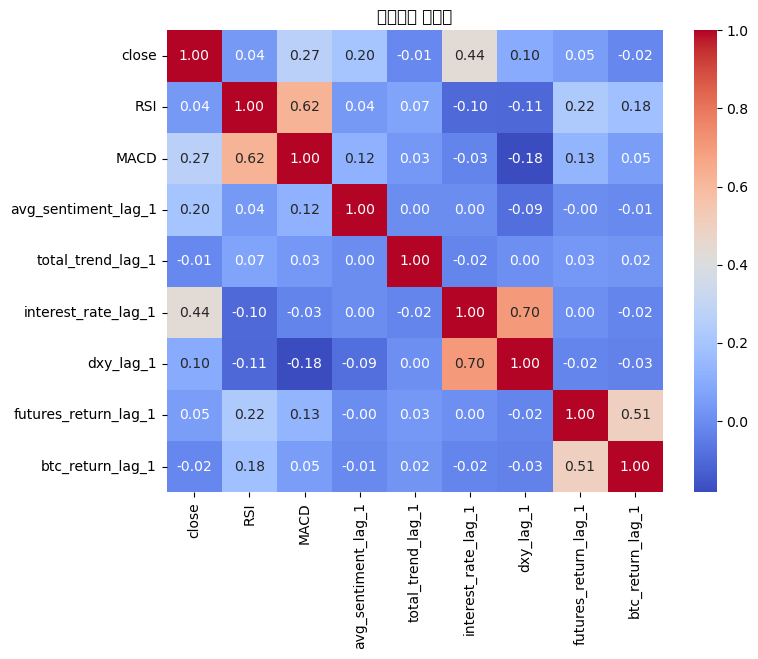


[상관관계 - 텍스트 출력]
                         close       RSI      MACD  avg_sentiment_lag_1  total_trend_lag_1  interest_rate_lag_1  dxy_lag_1  futures_return_lag_1  btc_return_lag_1
close                 1.000000  0.036382  0.268064             0.196880          -0.011852             0.435674   0.098178              0.048548         -0.020026
RSI                   0.036382  1.000000  0.621991             0.038552           0.074644            -0.099579  -0.107603              0.224864          0.182307
MACD                  0.268064  0.621991  1.000000             0.120479           0.034136            -0.028348  -0.182430              0.132078          0.052526
avg_sentiment_lag_1   0.196880  0.038552  0.120479             1.000000           0.000007             0.002000  -0.086324             -0.000751         -0.009230
total_trend_lag_1    -0.011852  0.074644  0.034136             0.000007           1.000000            -0.023712   0.004730              0.030524          0.021724
inter

In [8]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import shap
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------
# Granger 인과성 분석
# ---------------------------
def run_extended_granger(granger_df, target_col='close', maxlag=5):
    granger_df = granger_df.set_index('date')
    result = {}
    
    # 분석 변수 매핑
    var_mapping = {
        'avg_sentiment_lag_1': '뉴스 감성',
        'RSI': 'RSI',
        'MACD': 'MACD',
        'total_trend_lag_1': '구글 트렌드',
    }
    
    # 거시경제 및 외부 변수 추가
    if 'interest_rate_lag_1' in granger_df.columns:
        var_mapping['interest_rate_lag_1'] = '금리'
    if 'dxy_lag_1' in granger_df.columns:
        var_mapping['dxy_lag_1'] = 'DXY'
    if 'futures_return_lag_1' in granger_df.columns:
        var_mapping['futures_return_lag_1'] = '선물 수익률'
    if 'btc_return_lag_1' in granger_df.columns:
        var_mapping['btc_return_lag_1'] = 'BTC 수익률'
    
    for var in var_mapping.keys():
        try:
            data = granger_df[[var, target_col]]
            test = grangercausalitytests(data, maxlag=maxlag, verbose=False)
            p_values = [round(test[i + 1][0]['ssr_ftest'][1], 4) for i in range(maxlag)]
            result[var_mapping[var]] = p_values
        except Exception:
            result[var_mapping[var]] = ['ERROR'] * maxlag
    
    return pd.DataFrame(result, index=[f"Lag {i+1}" for i in range(maxlag)])

# ---------------------------
# SHAP 기반 XGBoost 피처 중요도
# ---------------------------
def run_xgboost_shap(df, features):
    df_model = df.dropna(subset=features + ['target'])
    df_model = df_model[df_model['target'].isin([0, 1])]
    
    X = df_model[features]
    y = df_model['target']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)
    
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_test)
    
    # 시각화
    shap.summary_plot(shap_values, X_test, max_display=20)
    
    # 텍스트 출력
    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
    shap_text = pd.DataFrame({'Feature': X_test.columns, 'Mean |SHAP|': mean_abs_shap})
    shap_text = shap_text.sort_values(by='Mean |SHAP|', ascending=False)
    print("\n[SHAP 피처 중요도 - 텍스트 출력]")
    print(shap_text.to_string(index=False))
    return shap_text

# ---------------------------
# 상관관계 히트맵
# ---------------------------
def plot_correlation_heatmap(df, columns):
    corr_matrix = df[columns].corr()
    plt.figure(figsize=(8,6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("상관관계 히트맵")
    plt.show()
    
    # 텍스트 출력
    print("\n[상관관계 - 텍스트 출력]")
    print(corr_matrix.to_string())

# ---------------------------
# Lag 피처 누락 체크 및 생성
# ---------------------------
if 'total_trend' in df.columns and 'total_trend_lag_1' not in df.columns:
    df['total_trend_lag_1'] = df['total_trend'].shift(1)

# ---------------------------
# Granger 분석 실행
# ---------------------------
granger_cols = ['date', 'close', 'avg_sentiment_lag_1', 'RSI', 'MACD', 'total_trend_lag_1',
                'interest_rate_lag_1', 'dxy_lag_1', 'futures_return_lag_1', 'btc_return_lag_1']

granger_df = df[granger_cols].dropna().copy()

print("[확장 Granger 인과성 분석 - 전체]")
extended_granger_result = run_extended_granger(granger_df)
print(extended_granger_result)

etf_date = pd.to_datetime("2024-01-10")
print("\n[Granger 분석 - ETF 승인 이전]")
extended_granger_pre = run_extended_granger(granger_df[granger_df['date'] < etf_date])
print(extended_granger_pre)

print("\n[Granger 분석 - ETF 승인 이후]")
extended_granger_post = run_extended_granger(granger_df[granger_df['date'] >= etf_date])
print(extended_granger_post)

# ---------------------------
# SHAP 분석
# ---------------------------
all_features_existing = [f for f in all_features if f in df.columns]
df[all_features_existing] = df[all_features_existing].fillna(method='ffill').fillna(0)

print("\n[SHAP 분석]")
shap_text = run_xgboost_shap(df, all_features_existing)

# ---------------------------
# 상관관계 히트맵
# ---------------------------
plot_correlation_heatmap(df, ['close', 'RSI', 'MACD', 'avg_sentiment_lag_1', 'total_trend_lag_1',
                              'interest_rate_lag_1', 'dxy_lag_1', 'futures_return_lag_1', 'btc_return_lag_1'])


In [10]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import mutual_info_regression, SelectKBest
from scipy.stats import pearsonr, spearmanr, normaltest
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
import warnings
warnings.filterwarnings('ignore')

class EnhancedFeatureAnalyzer:
    def __init__(self, df):
        self.df = df.copy()
        self.results = {}
        self.etf_date = pd.to_datetime("2024-01-10")
        self.major_events = {
            "2021-08-05": "EIP-1559 London Hard Fork",
            "2022-09-15": "Ethereum Merge",
            "2023-04-12": "Shanghai Upgrade",
            "2024-01-10": "ETF Approval",
            "2024-03-13": "Dencun Upgrade"
        }
    
    def create_enhanced_sentiment_features(self):
        """뉴스 감성 피처를 다양화"""
        # 기본 감성 지표들
        self.df['sentiment_momentum'] = self.df['avg_sentiment'].rolling(5).mean()
        self.df['sentiment_volatility'] = self.df['avg_sentiment'].rolling(10).std()
        self.df['sentiment_trend'] = self.df['avg_sentiment'].diff(3)
        
        # 감성 강도 지표
        self.df['sentiment_strength'] = np.abs(self.df['avg_sentiment'])
        self.df['sentiment_consistency'] = self.df['avg_sentiment'].rolling(7).apply(
            lambda x: len(x[x > 0]) / len(x) if len(x) > 0 else 0
        )
        
        # 뉴스 볼륨과 감성의 결합
        self.df['weighted_sentiment'] = self.df['avg_sentiment'] * np.log1p(self.df['total_news'])
        self.df['sentiment_news_ratio'] = self.df['avg_sentiment'] / (self.df['total_news'] + 1)
        
        # 극단 감성 지표
        self.df['extreme_positive'] = (self.df['avg_sentiment'] > self.df['avg_sentiment'].quantile(0.9)).astype(int)
        self.df['extreme_negative'] = (self.df['avg_sentiment'] < self.df['avg_sentiment'].quantile(0.1)).astype(int)
        
        # 감성 전환점
        self.df['sentiment_reversal'] = ((self.df['avg_sentiment'].shift(1) < 0) & (self.df['avg_sentiment'] > 0)).astype(int)
        
        # 시차별 감성 피처
        for lag in [1, 3, 5, 7]:
            self.df[f'sentiment_momentum_lag_{lag}'] = self.df['sentiment_momentum'].shift(lag)
            self.df[f'sentiment_strength_lag_{lag}'] = self.df['sentiment_strength'].shift(lag)
            self.df[f'weighted_sentiment_lag_{lag}'] = self.df['weighted_sentiment'].shift(lag)
    
    def create_event_features(self):
        """주요 이벤트 전후 피처 생성"""
        for event_date, event_name in self.major_events.items():
            event_dt = pd.to_datetime(event_date)
            
            # 이벤트 전후 더미 변수
            self.df[f'pre_{event_name.replace(" ", "_").lower()}'] = (
                (self.df['date'] >= event_dt - pd.Timedelta(days=30)) & 
                (self.df['date'] < event_dt)
            ).astype(int)
            
            self.df[f'post_{event_name.replace(" ", "_").lower()}'] = (
                (self.df['date'] >= event_dt) & 
                (self.df['date'] < event_dt + pd.Timedelta(days=30))
            ).astype(int)
            
            # 이벤트로부터의 거리
            self.df[f'days_from_{event_name.replace(" ", "_").lower()}'] = (
                self.df['date'] - event_dt
            ).dt.days.clip(-365, 365)
    
    def check_stationarity(self, series, name):
        """시계열 정상성 검정"""
        try:
            result = adfuller(series.dropna())
            return {
                'variable': name,
                'adf_statistic': result[0],
                'p_value': result[1],
                'is_stationary': result[1] < 0.05
            }
        except:
            return {'variable': name, 'adf_statistic': np.nan, 'p_value': np.nan, 'is_stationary': False}
    
    def enhanced_granger_causality(self, target_col='close', maxlag=5):
        """개선된 Granger 인과성 분석"""
        granger_features = [
            'sentiment_momentum_lag_1', 'sentiment_strength_lag_1', 'weighted_sentiment_lag_1',
            'RSI', 'MACD', 'total_trend_lag_1', 'interest_rate_lag_1', 'dxy_lag_1',
            'futures_return_lag_1', 'btc_return_lag_1'
        ]
        
        # 사용 가능한 피처만 필터링
        available_features = [f for f in granger_features if f in self.df.columns]
        granger_df = self.df[['date', target_col] + available_features].dropna()
        
        if len(granger_df) < 50:
            return pd.DataFrame()
        
        # 정상성 검정
        stationarity_results = []
        for col in [target_col] + available_features:
            stationarity_results.append(self.check_stationarity(granger_df[col], col))
        
        # 비정상 시계열 차분
        granger_df_processed = granger_df.copy()
        for result in stationarity_results:
            if not result['is_stationary'] and not pd.isna(result['p_value']):
                col = result['variable']
                granger_df_processed[f'{col}_diff'] = granger_df_processed[col].diff()
        
        # Granger 인과성 테스트
        results = {}
        for feature in available_features:
            try:
                test_data = granger_df_processed[[feature, target_col]].dropna()
                if len(test_data) < maxlag * 2:
                    continue
                    
                test_result = grangercausalitytests(test_data, maxlag=maxlag, verbose=False)
                p_values = [test_result[i+1][0]['ssr_ftest'][1] for i in range(maxlag)]
                results[feature] = p_values
            except:
                results[feature] = [np.nan] * maxlag
        
        return pd.DataFrame(results, index=[f"Lag_{i+1}" for i in range(maxlag)])
    
    def mutual_information_analysis(self, target_col='return'):
        """상호정보량 분석"""
        feature_cols = [col for col in self.df.columns if 
                       any(x in col for x in ['sentiment', 'trend', 'RSI', 'MACD', 'return_lag', 'ratio'])]
        
        clean_df = self.df[feature_cols + [target_col]].dropna()
        if len(clean_df) < 50:
            return pd.DataFrame()
        
        X = clean_df[feature_cols]
        y = clean_df[target_col]
        
        # 연속형 변수에 대한 상호정보량
        mi_scores = mutual_info_regression(X, y, random_state=42)
        
        results = pd.DataFrame({
            'Feature': feature_cols,
            'Mutual_Info': mi_scores
        }).sort_values('Mutual_Info', ascending=False)
        
        return results.head(20)
    
    def regime_based_analysis(self):
        """시장 체제별 분석"""
        # 변동성 체제 분류
        self.df['volatility'] = self.df['return'].rolling(20).std()
        vol_quantiles = self.df['volatility'].quantile([0.33, 0.67])
        
        self.df['volatility_regime'] = pd.cut(
            self.df['volatility'],
            bins=[-np.inf, vol_quantiles.iloc[0], vol_quantiles.iloc[1], np.inf],
            labels=['Low', 'Medium', 'High']
        )
        
        # 각 체제별 상관관계 분석
        regime_correlations = {}
        feature_cols = ['avg_sentiment', 'total_trend_lag_1', 'RSI', 'MACD', 'btc_return_lag_1']
        available_features = [f for f in feature_cols if f in self.df.columns]
        
        for regime in ['Low', 'Medium', 'High']:
            regime_data = self.df[self.df['volatility_regime'] == regime]
            if len(regime_data) > 20:
                correlations = {}
                for feature in available_features:
                    try:
                        corr, p_val = pearsonr(
                            regime_data[feature].dropna(), 
                            regime_data['return'][regime_data[feature].notna()]
                        )
                        correlations[feature] = {'correlation': corr, 'p_value': p_val}
                    except:
                        correlations[feature] = {'correlation': np.nan, 'p_value': np.nan}
                
                regime_correlations[regime] = correlations
        
        return regime_correlations
    
    def feature_importance_ensemble(self, target_col='target'):
        """앙상블 기반 피처 중요도"""
        feature_cols = [col for col in self.df.columns if 
                       any(x in col for x in ['sentiment', 'trend', 'RSI', 'MACD', 'return_lag', 'ratio', 'btc', 'dxy'])]
        
        clean_df = self.df[feature_cols + [target_col]].dropna()
        clean_df = clean_df[clean_df[target_col].isin([0, 1])]
        
        if len(clean_df) < 100:
            return {}
        
        X = clean_df[feature_cols]
        y = clean_df[target_col]
        
        # 데이터 스케일링
        scaler = RobustScaler()
        X_scaled = scaler.fit_transform(X)
        X_scaled_df = pd.DataFrame(X_scaled, columns=feature_cols)
        
        importance_results = {}
        
        # 1. Random Forest 중요도
        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf.fit(X_scaled_df, y)
        importance_results['RandomForest'] = dict(zip(feature_cols, rf.feature_importances_))
        
        # 2. XGBoost 중요도
        xgb = XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
        xgb.fit(X_scaled_df, y)
        importance_results['XGBoost'] = dict(zip(feature_cols, xgb.feature_importances_))
        
        # 3. LASSO 계수
        lasso = LassoCV(cv=5, random_state=42)
        lasso.fit(X_scaled_df, y)
        importance_results['LASSO'] = dict(zip(feature_cols, np.abs(lasso.coef_)))
        
        # 평균 중요도 계산
        avg_importance = {}
        for feature in feature_cols:
            scores = [importance_results[method].get(feature, 0) for method in importance_results.keys()]
            avg_importance[feature] = np.mean(scores)
        
        return avg_importance
    
    def event_impact_analysis(self):
        """이벤트 영향 분석"""
        event_impacts = {}
        
        for event_date, event_name in self.major_events.items():
            event_dt = pd.to_datetime(event_date)
            
            # 이벤트 전후 30일 데이터
            pre_event = self.df[
                (self.df['date'] >= event_dt - pd.Timedelta(days=30)) & 
                (self.df['date'] < event_dt)
            ]
            post_event = self.df[
                (self.df['date'] >= event_dt) & 
                (self.df['date'] < event_dt + pd.Timedelta(days=30))
            ]
            
            if len(pre_event) > 5 and len(post_event) > 5:
                # 가격 변화
                price_change = (post_event['close'].mean() - pre_event['close'].mean()) / pre_event['close'].mean()
                
                # 변동성 변화
                vol_change = post_event['return'].std() - pre_event['return'].std()
                
                # 감성 변화
                sentiment_change = post_event['avg_sentiment'].mean() - pre_event['avg_sentiment'].mean()
                
                # 뉴스 볼륨 변화
                news_change = post_event['total_news'].mean() - pre_event['total_news'].mean()
                
                event_impacts[event_name] = {
                    'price_change_pct': price_change * 100,
                    'volatility_change': vol_change,
                    'sentiment_change': sentiment_change,
                    'news_volume_change': news_change
                }
        
        return event_impacts
    
    def run_comprehensive_analysis(self):
        """종합 분석 실행"""
        print("=== 종합 피처 영향 분석 ===\n")
        
        # 1. 향상된 감성 피처 생성
        self.create_enhanced_sentiment_features()
        
        # 2. 이벤트 피처 생성
        self.create_event_features()
        
        # 3. Granger 인과성 분석
        print("1. Granger 인과성 분석")
        granger_results = self.enhanced_granger_causality()
        if not granger_results.empty:
            print(granger_results.round(4))
        
        # 4. 상호정보량 분석
        print("\n2. 상호정보량 분석 (Top 10)")
        mi_results = self.mutual_information_analysis()
        if not mi_results.empty:
            print(mi_results.head(10).to_string(index=False))
        
        # 5. 체제별 분석
        print("\n3. 변동성 체제별 상관관계")
        regime_results = self.regime_based_analysis()
        for regime, correlations in regime_results.items():
            print(f"\n[{regime} Volatility Regime]")
            for feature, stats in correlations.items():
                print(f"{feature}: r={stats['correlation']:.3f}, p={stats['p_value']:.3f}")
        
        # 6. 앙상블 피처 중요도
        print("\n4. 앙상블 피처 중요도 (Top 15)")
        importance_results = self.feature_importance_ensemble()
        if importance_results:
            sorted_importance = sorted(importance_results.items(), key=lambda x: x[1], reverse=True)
            for feature, importance in sorted_importance[:15]:
                print(f"{feature}: {importance:.4f}")
        
        # 7. 이벤트 영향 분석
        print("\n5. 주요 이벤트 영향 분석")
        event_impacts = self.event_impact_analysis()
        for event, impacts in event_impacts.items():
            print(f"\n[{event}]")
            print(f"가격 변화: {impacts['price_change_pct']:.2f}%")
            print(f"변동성 변화: {impacts['volatility_change']:.4f}")
            print(f"감성 변화: {impacts['sentiment_change']:.4f}")
            print(f"뉴스 볼륨 변화: {impacts['news_volume_change']:.2f}")
        
        return {
            'granger': granger_results,
            'mutual_info': mi_results,
            'regime_analysis': regime_results,
            'feature_importance': importance_results,
            'event_impacts': event_impacts
        }

def create_advanced_interaction_features(df):
    """고급 상호작용 피처 생성"""
    # 감성과 기술적 지표 상호작용
    df['sentiment_rsi_interaction'] = df['avg_sentiment'] * df['RSI'] / 100
    df['sentiment_macd_interaction'] = df['avg_sentiment'] * df['MACD']
    
    # 시장 상황별 감성 효과
    df['bull_market_sentiment'] = np.where(
        df['SMA_12'] > df['SMA_26'], 
        df['avg_sentiment'], 
        0
    )
    df['bear_market_sentiment'] = np.where(
        df['SMA_12'] <= df['SMA_26'], 
        df['avg_sentiment'], 
        0
    )
    
    # 거래량과 감성 결합
    if 'volume_ratio' in df.columns:
        df['high_volume_sentiment'] = np.where(
            df['volume_ratio'] > 1.5,
            df['avg_sentiment'],
            0
        )
    
    # 극단 상황 지표
    df['extreme_sentiment_high_vol'] = (
        (np.abs(df['avg_sentiment']) > df['avg_sentiment'].std()) & 
        (df.get('volume_ratio', 1) > 1.2)
    ).astype(int)
    
    # 멀티 타임프레임 피처
    for window in [3, 7, 14]:
        df[f'sentiment_ma_{window}'] = df['avg_sentiment'].rolling(window).mean()
        df[f'price_ma_{window}'] = df['close'].rolling(window).mean()
        df[f'sentiment_price_div_{window}'] = (
            df['avg_sentiment'] - df[f'sentiment_ma_{window}']
        ) * (df['close'] - df[f'price_ma_{window}'])
    
    return df

# 분석 실행 함수
def run_feature_analysis(df):
    """피처 분석 실행"""
    # 고급 상호작용 피처 추가
    df = create_advanced_interaction_features(df)
    
    # 분석 실행
    analyzer = EnhancedFeatureAnalyzer(df)
    results = analyzer.run_comprehensive_analysis()
    
    return results, analyzer.df

results, enhanced_df = run_feature_analysis(df)

=== 종합 피처 영향 분석 ===

1. Granger 인과성 분석
       sentiment_momentum_lag_1  sentiment_strength_lag_1  \
Lag_1                    0.0013                    0.0033   
Lag_2                    0.0001                    0.0184   
Lag_3                    0.0001                    0.0582   
Lag_4                    0.0000                    0.0215   
Lag_5                    0.0000                    0.0224   

       weighted_sentiment_lag_1     RSI    MACD  total_trend_lag_1  \
Lag_1                       0.0  0.0181  0.0306             0.3395   
Lag_2                       0.0  0.0060  0.0063             0.2776   
Lag_3                       0.0  0.0029  0.3276             0.0133   
Lag_4                       0.0  0.0011  0.3851             0.0224   
Lag_5                       0.0  0.0009  0.2228             0.0414   

       interest_rate_lag_1  dxy_lag_1  futures_return_lag_1  btc_return_lag_1  
Lag_1               0.1921     0.2448                0.0152            0.3973  
Lag_2        

In [11]:
import yfinance as yf
import pandas as pd
import numpy as np
import requests
import time
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

class MarketDataCollector:
    def __init__(self, start_date="2020-01-01", end_date="2025-09-28"):
        self.start_date = start_date
        self.end_date = end_date
        self.sleep_time = 1
        
    def safe_request(self, func, *args, **kwargs):
        """API 호출 제한 방지를 위한 안전 요청"""
        try:
            time.sleep(self.sleep_time)
            return func(*args, **kwargs)
        except Exception as e:
            print(f"API 요청 실패: {e}")
            time.sleep(5)
            return None
    
    def fetch_traditional_markets(self):
        """전통 금융 시장 지표 수집"""
        symbols = {
            '^GSPC': 'sp500',      # S&P 500
            '^IXIC': 'nasdaq',     # NASDAQ
            '^VIX': 'vix',         # VIX 공포지수
            'GC=F': 'gold',        # 금 선물
            'CL=F': 'oil',         # 원유 선물
            '^TNX': 'treasury_10y', # 10년 국채 수익률
            'DX-Y.NYB': 'dxy'      # 달러 지수
        }
        
        traditional_data = pd.DataFrame()
        
        for symbol, name in symbols.items():
            try:
                data = self.safe_request(yf.download, symbol, 
                                       start=self.start_date, end=self.end_date, 
                                       progress=False)
                if not data.empty:
                    if isinstance(data.columns, pd.MultiIndex):
                        data.columns = data.columns.get_level_values(0)
                    
                    close_col = next((c for c in data.columns if 'close' in str(c).lower()), None)
                    if close_col:
                        temp_df = data.reset_index()
                        temp_df = temp_df.rename(columns={'Date': 'date', close_col: name})
                        temp_df['date'] = pd.to_datetime(temp_df['date']).dt.normalize()
                        
                        if traditional_data.empty:
                            traditional_data = temp_df[['date', name]]
                        else:
                            traditional_data = pd.merge(traditional_data, temp_df[['date', name]], 
                                                      on='date', how='outer')
            except Exception as e:
                print(f"{symbol} 수집 실패: {e}")
                continue
        
        return traditional_data
    
    def fetch_crypto_correlations(self):
        """주요 암호화폐 상관관계 데이터"""
        crypto_symbols = {
            'BTC-USD': 'btc_price',
            'ADA-USD': 'ada_price',
            'DOT-USD': 'dot_price',
            'LINK-USD': 'link_price',
            'UNI-USD': 'uni_price'
        }
        
        crypto_data = pd.DataFrame()
        
        for symbol, name in crypto_symbols.items():
            try:
                data = self.safe_request(yf.download, symbol,
                                       start=self.start_date, end=self.end_date,
                                       progress=False)
                if not data.empty:
                    if isinstance(data.columns, pd.MultiIndex):
                        data.columns = data.columns.get_level_values(0)
                    
                    close_col = next((c for c in data.columns if 'close' in str(c).lower()), None)
                    volume_col = next((c for c in data.columns if 'volume' in str(c).lower()), None)
                    
                    if close_col:
                        temp_df = data.reset_index()
                        temp_df = temp_df.rename(columns={'Date': 'date'})
                        temp_df['date'] = pd.to_datetime(temp_df['date']).dt.normalize()
                        
                        temp_df[name] = temp_df[close_col]
                        temp_df[f'{name}_volume'] = temp_df[volume_col] if volume_col else 0
                        temp_df[f'{name}_return'] = temp_df[name].pct_change()
                        
                        if crypto_data.empty:
                            crypto_data = temp_df[['date', name, f'{name}_volume', f'{name}_return']]
                        else:
                            crypto_data = pd.merge(crypto_data, 
                                                 temp_df[['date', name, f'{name}_volume', f'{name}_return']], 
                                                 on='date', how='outer')
            except Exception as e:
                print(f"{symbol} 수집 실패: {e}")
                continue
                
        return crypto_data
    
    def fetch_defi_data(self):
        """DefiLlama API를 통한 실제 DeFi 데이터 수집"""
        try:
            base_url = "https://api.llama.fi"
            
            # 이더리움 TVL 히스토리 수집
            eth_tvl_url = f"{base_url}/charts/Ethereum"
            response = self.safe_request(requests.get, eth_tvl_url)
            
            if response and response.status_code == 200:
                tvl_data = response.json()
                df = pd.DataFrame(tvl_data)
                df['date'] = pd.to_datetime(df['date'], unit='s').dt.normalize()
                df = df.rename(columns={'totalLiquidityUSD': 'ethereum_tvl'})
                df = df[df['date'] >= pd.to_datetime(self.start_date)]
                
                # 주요 프로토콜 TVL 수집
                protocols = {
                    'uniswap': 'uniswap_tvl',
                    'aave-v3': 'aave_tvl', 
                    'lido': 'lido_tvl',
                    'curve': 'curve_tvl'
                }
                
                for protocol_name, col_name in protocols.items():
                    try:
                        url = f"{base_url}/protocol/{protocol_name}"
                        prot_response = self.safe_request(requests.get, url)
                        
                        if prot_response and prot_response.status_code == 200:
                            prot_data = prot_response.json()
                            if 'chainTvls' in prot_data and 'Ethereum' in prot_data['chainTvls']:
                                eth_tvl_data = prot_data['chainTvls']['Ethereum']['tvl']
                                prot_df = pd.DataFrame(eth_tvl_data)
                                prot_df['date'] = pd.to_datetime(prot_df['date'], unit='s').dt.normalize()
                                prot_df = prot_df.rename(columns={'totalLiquidityUSD': col_name})
                                prot_df = prot_df[prot_df['date'] >= pd.to_datetime(self.start_date)]
                                
                                df = pd.merge(df, prot_df[['date', col_name]], on='date', how='left')
                    except:
                        continue
                
                # 파생 지표 계산
                df = df.fillna(method='ffill').fillna(0)
                if 'uniswap_tvl' in df.columns:
                    df['uniswap_dominance'] = (df['uniswap_tvl'] / df['ethereum_tvl']) * 100
                df['tvl_growth_7d'] = df['ethereum_tvl'].pct_change(7)
                df['tvl_volatility_30d'] = df['ethereum_tvl'].rolling(30).std()
                
                # DeFi 이벤트 더미 변수
                defi_events = {
                    'uniswap_v2_launch': '2020-05-18',
                    'compound_farming': '2020-06-16', 
                    'sushiswap_launch': '2020-08-28',
                    'uniswap_v3_launch': '2021-05-05',
                    'ust_depeg': '2022-05-09'
                }
                
                for event, date in defi_events.items():
                    event_date = pd.to_datetime(date)
                    df[f'{event}_dummy'] = (df['date'] == event_date).astype(int)
                    df[f'{event}_after'] = (df['date'] > event_date).astype(int)
                
                return df
                
        except Exception as e:
            return pd.DataFrame()
        
        return pd.DataFrame()
    
    def create_major_events_dummies(self, df):
        """주요 이벤트 더미 변수 생성"""
        major_events = {
            "2020-03-12": "covid_crash",
            "2020-12-01": "eth2_beacon_launch",
            "2021-08-05": "london_hardfork",
            "2021-11-10": "eth_ath_2021",
            "2022-05-09": "terra_collapse",
            "2022-06-15": "celsius_freeze",
            "2022-09-15": "ethereum_merge",
            "2022-11-08": "ftx_collapse",
            "2023-04-12": "shanghai_upgrade",
            "2024-01-10": "btc_etf_approval",
            "2024-07-23": "eth_etf_approval",
            "2025-06-21": "flash_crash_2025"
        }
        
        for date_str, event_name in major_events.items():
            event_date = pd.to_datetime(date_str)
            
            # 이벤트 당일 더미
            df[f'{event_name}_day'] = (df['date'] == event_date).astype(int)
            
            # 이벤트 전 7일 더미
            df[f'{event_name}_pre7'] = (
                (df['date'] >= event_date - pd.Timedelta(days=7)) & 
                (df['date'] < event_date)
            ).astype(int)
            
            # 이벤트 후 7일 더미
            df[f'{event_name}_post7'] = (
                (df['date'] > event_date) & 
                (df['date'] <= event_date + pd.Timedelta(days=7))
            ).astype(int)
            
            # 이벤트 후 30일 더미 (장기 효과)
            df[f'{event_name}_post30'] = (
                (df['date'] > event_date) & 
                (df['date'] <= event_date + pd.Timedelta(days=30))
            ).astype(int)
        
        return df
    
    def create_market_regime_features(self, df):
        """시장 체제 분류 피처 생성"""
        # VIX 기반 공포/탐욕 체제
        if 'vix' in df.columns:
            df['market_fear'] = (df['vix'] > 30).astype(int)
            df['market_extreme_fear'] = (df['vix'] > 40).astype(int)
            df['market_complacency'] = (df['vix'] < 15).astype(int)
        
        # 금리 환경
        if 'treasury_10y' in df.columns:
            df['high_interest_rate'] = (df['treasury_10y'] > 4.0).astype(int)
            df['low_interest_rate'] = (df['treasury_10y'] < 2.0).astype(int)
            df['rate_rising'] = (df['treasury_10y'].diff() > 0.1).astype(int)
        
        # 달러 강약
        if 'dxy' in df.columns:
            df['strong_dollar'] = (df['dxy'] > df['dxy'].rolling(90).mean()).astype(int)
            df['dollar_momentum'] = df['dxy'].pct_change(5)
        
        # 리스크 온/오프 환경
        if 'sp500' in df.columns and 'gold' in df.columns:
            sp500_ret = df['sp500'].pct_change()
            gold_ret = df['gold'].pct_change()
            df['risk_on'] = (sp500_ret > gold_ret).astype(int)
            df['risk_off'] = (gold_ret > sp500_ret).astype(int)
        
        return df
    
    def create_correlation_features(self, df):
        """동적 상관관계 피처 생성"""
        if 'btc_price' in df.columns and 'close' in df.columns:
            # 30일 롤링 상관관계
            btc_ret = df['btc_price'].pct_change()
            eth_ret = df['close'].pct_change()
            df['btc_eth_corr_30d'] = btc_ret.rolling(30).corr(eth_ret)
            
            # 상관관계 변화율
            df['corr_change'] = df['btc_eth_corr_30d'].diff()
        
        if 'sp500' in df.columns and 'close' in df.columns:
            # 전통시장과의 상관관계
            sp_ret = df['sp500'].pct_change()
            eth_ret = df['close'].pct_change()
            df['sp500_eth_corr_30d'] = sp_ret.rolling(30).corr(eth_ret)
        
        return df
    
    def collect_all_data(self, base_df):
        """모든 데이터 수집 및 통합"""
        print("=== 종합 시장 데이터 수집 시작 ===\n")
        
        # 1. 전통 금융 시장 데이터
        print("1. 전통 금융 시장 데이터 수집 중...")
        traditional_data = self.fetch_traditional_markets()
        if not traditional_data.empty:
            base_df = pd.merge(base_df, traditional_data, on='date', how='left')
            print(f"전통 시장 데이터 {len(traditional_data)} 행 수집 완료")
        
        # 2. 암호화폐 상관관계 데이터
        print("2. 암호화폐 상관관계 데이터 수집 중...")
        crypto_data = self.fetch_crypto_correlations()
        if not crypto_data.empty:
            base_df = pd.merge(base_df, crypto_data, on='date', how='left')
            print(f"암호화폐 데이터 {len(crypto_data)} 행 수집 완료")
        
        # 3. DeFi 데이터 (더미)
        print("3. DeFi 데이터 수집 중...")
        defi_data = self.fetch_defi_data()
        if not defi_data.empty:
            base_df = pd.merge(base_df, defi_data, on='date', how='left')
            print("DeFi 더미 데이터 생성 완료")
        
        # 4. 이벤트 더미 변수 생성
        print("4. 주요 이벤트 더미 변수 생성 중...")
        base_df = self.create_major_events_dummies(base_df)
        print("이벤트 더미 변수 생성 완료")
        
        # 5. 시장 체제 피처 생성
        print("5. 시장 체제 피처 생성 중...")
        base_df = self.create_market_regime_features(base_df)
        print("시장 체제 피처 생성 완료")
        
        # 6. 상관관계 피처 생성
        print("6. 동적 상관관계 피처 생성 중...")
        base_df = self.create_correlation_features(base_df)
        print("상관관계 피처 생성 완료")
        
        # 데이터 전처리
        numeric_cols = base_df.select_dtypes(include=[np.number]).columns
        base_df[numeric_cols] = base_df[numeric_cols].fillna(method='ffill').fillna(0)
        
        print(f"\n=== 데이터 수집 완료 ===")
        print(f"총 {len(base_df)} 행, {len(base_df.columns)} 컬럼")
        print(f"새로 추가된 피처 수: {len(base_df.columns) - len(['date', 'close'])}")
        
        return base_df

def analyze_new_features_impact(enhanced_df):
    """새로운 피처들의 영향 분석"""
    print("\n=== 새 피처 영향 분석 ===")
    
    # 이더리움 가격과의 상관관계 분석
    price_correlations = {}
    numeric_cols = enhanced_df.select_dtypes(include=[np.number]).columns
    
    for col in numeric_cols:
        if col not in ['close'] and len(enhanced_df[col].dropna()) > 50:
            try:
                corr = enhanced_df['close'].corr(enhanced_df[col])
                if not pd.isna(corr) and abs(corr) > 0.1:  # 상관관계 0.1 이상만
                    price_correlations[col] = corr
            except:
                continue
    
    # 상관관계 높은 순으로 정렬
    sorted_correlations = sorted(price_correlations.items(), 
                               key=lambda x: abs(x[1]), reverse=True)
    
    print("이더리움 가격과 상관관계가 높은 새 피처들 (Top 15):")
    for feature, corr in sorted_correlations[:15]:
        print(f"{feature}: {corr:.3f}")
    
    # 이벤트 더미 변수들의 평균 효과 분석
    event_features = [col for col in enhanced_df.columns if any(x in col for x in ['_day', '_pre7', '_post7', '_post30'])]
    
    print(f"\n생성된 이벤트 더미 변수: {len(event_features)}개")
    
    # 주요 이벤트들의 실제 가격 변화 분석
    major_events_impact = {}
    for event_col in event_features:
        if '_day' in event_col:
            event_days = enhanced_df[enhanced_df[event_col] == 1]
            if len(event_days) > 0:
                pre_price = enhanced_df[enhanced_df['date'] < event_days['date'].iloc[0]]['close'].iloc[-1] if len(enhanced_df[enhanced_df['date'] < event_days['date'].iloc[0]]) > 0 else None
                event_price = event_days['close'].iloc[0]
                if pre_price:
                    price_change = (event_price - pre_price) / pre_price * 100
                    major_events_impact[event_col.replace('_day', '')] = price_change
    
    print(f"\n주요 이벤트 당일 가격 변화:")
    for event, change in major_events_impact.items():
        print(f"{event}: {change:.2f}%")
    
    return enhanced_df, sorted_correlations[:15]

# 사용 예시
def run_comprehensive_data_collection(base_df):
    """종합 데이터 수집 실행"""
    collector = MarketDataCollector()
    enhanced_df = collector.collect_all_data(base_df)
    enhanced_df, top_correlations = analyze_new_features_impact(enhanced_df)
    
    return enhanced_df, top_correlations


enhanced_df, top_correlations = run_comprehensive_data_collection(df)

=== 종합 시장 데이터 수집 시작 ===

1. 전통 금융 시장 데이터 수집 중...
전통 시장 데이터 1445 행 수집 완료
2. 암호화폐 상관관계 데이터 수집 중...
암호화폐 데이터 2097 행 수집 완료
3. DeFi 데이터 수집 중...
DeFi 더미 데이터 생성 완료
4. 주요 이벤트 더미 변수 생성 중...
이벤트 더미 변수 생성 완료
5. 시장 체제 피처 생성 중...
시장 체제 피처 생성 완료
6. 동적 상관관계 피처 생성 중...
상관관계 피처 생성 완료

=== 데이터 수집 완료 ===
총 2101 행, 202 컬럼
새로 추가된 피처 수: 200

=== 새 피처 영향 분석 ===
이더리움 가격과 상관관계가 높은 새 피처들 (Top 15):
price_ma_3: 0.998
price_ma_7: 0.994
futures_close: 0.989
SMA_12: 0.988
price_ma_14: 0.986
SMA_26: 0.973
ethereum_tvl: 0.934
nasdaq: 0.789
sp500: 0.777
uniswap_tvl: 0.771
btc_close: 0.753
btc_price: 0.753
price_volume: 0.728
tvl_volatility_30d: 0.687
ada_price: 0.675

생성된 이벤트 더미 변수: 48개

주요 이벤트 당일 가격 변화:
covid_crash: -42.35%
eth2_beacon_launch: -4.48%
london_hardfork: 3.77%
eth_ath_2021: -2.09%
terra_collapse: -10.81%
celsius_freeze: 1.78%
ethereum_merge: -9.97%
ftx_collapse: -15.03%
shanghai_upgrade: 1.51%
btc_etf_approval: 10.12%
eth_etf_approval: 1.21%
flash_crash_2025: -4.44%


In [12]:

# 4. 단계별 모델 학습 및 비교
print("\n[4단계] 단계별 모델 학습 및 성능 비교...")

# 데이터 분할을 위한 마스크
train_mask = df['date'] <= pd.to_datetime(TRAIN_END)
test_mask = df['date'] > pd.to_datetime(TRAIN_END)
y_train = df.loc[train_mask, 'target'].dropna()
y_test = df.loc[test_mask, 'target'].dropna()

all_results = []
feature_sets = []

# Step 1: 기본 가격 피쳐만
current_features = base_price_features
feature_sets.append(('Base_Price', current_features))

# Step 2: + 뉴스 피쳐
current_features = base_price_features + news_features + interaction_features
feature_sets.append(('Base+News', current_features))

# Step 3: + 거래량 피쳐
if volume_features:
    current_features = base_price_features + news_features + interaction_features + volume_features
    feature_sets.append(('Base+News+Volume', current_features))

# Step 4: + 거시경제 피쳐
if macro_features:
    current_features = base_price_features + news_features + interaction_features + volume_features + macro_features
    feature_sets.append(('Base+News+Volume+Macro', current_features))

# Step 5: + 선물 피쳐
if futures_features:
    current_features = base_price_features + news_features + interaction_features + volume_features + macro_features + futures_features
    feature_sets.append(('Base+News+Volume+Macro+Futures', current_features))

# Step 6: + 구글 트렌드 피쳐 (최종)
current_features = base_price_features + news_features + interaction_features + volume_features + macro_features + futures_features + trend_features
feature_sets.append(('All_Features', current_features))

# 각 피쳐셋에 대해 모델 학습
for set_name, features in feature_sets:
    print(f"\n--- {set_name} 모델 학습 ({len(features)}개 피쳐) ---")
    
    # 사용 가능한 피쳐만 필터링
    available_features = [f for f in features if f in df.columns]
    if len(available_features) == 0:
        continue
        
    print(f"사용된 피쳐: {available_features}")
    
    # 데이터 준비
    data_subset = df[['date'] + available_features + ['target']].dropna().reset_index(drop=True)
    
    if len(data_subset) < 100:  # 최소 데이터 요구사항
        print(f"데이터 부족: {len(data_subset)}개")
        continue
    
    train_mask_subset = data_subset['date'] <= pd.to_datetime(TRAIN_END)
    test_mask_subset = data_subset['date'] > pd.to_datetime(TRAIN_END)
    
    X_train = data_subset.loc[train_mask_subset, available_features].values
    X_test = data_subset.loc[test_mask_subset, available_features].values
    y_train = data_subset.loc[train_mask_subset, 'target'].values
    y_test = data_subset.loc[test_mask_subset, 'target'].values
    
    if len(y_train) == 0 or len(y_test) == 0:
        continue
    
    print(f"학습 샘플: {len(y_train)}, 테스트 샘플: {len(y_test)}")
    
    # 스케일링
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 기본 모델들
    step_results = train_models(X_train_scaled, X_test_scaled, y_train, y_test, set_name)
    
    # LSTM 모델
    lstm_result = train_lstm_model(X_train_scaled, X_test_scaled, y_train, y_test, f'{set_name}_LSTM')
    if not pd.isna(lstm_result.get('Accuracy')):
        step_results.append(lstm_result)
    
    # 결과 저장
    for result in step_results:
        result['Feature_Set'] = set_name
        result['Num_Features'] = len(available_features)
    
    all_results.extend(step_results)
    



[4단계] 단계별 모델 학습 및 성능 비교...

--- Base_Price 모델 학습 (11개 피쳐) ---
사용된 피쳐: ['return_lag_1', 'return_lag_2', 'return_lag_3', 'SMA_12', 'SMA_26', 'RSI', 'MACD', 'MACD_signal', 'SMA_cross', 'MACD_hist', 'RSI_over']
학습 샘플: 1561, 테스트 샘플: 224


2025-10-02 22:13:00.935419: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46589 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:1d:00.0, compute capability: 8.6
2025-10-02 22:13:05.370490: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2025-10-02 22:13:07.037041: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fafd9d8b810 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-02 22:13:07.037072: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2025-10-02 22:13:07.042032: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1759410787.143230   47172 device_compiler.h:186] Compiled cluster using XLA!  This line is 


--- Base+News 모델 학습 (19개 피쳐) ---
사용된 피쳐: ['return_lag_1', 'return_lag_2', 'return_lag_3', 'SMA_12', 'SMA_26', 'RSI', 'MACD', 'MACD_signal', 'SMA_cross', 'MACD_hist', 'RSI_over', 'pos_ratio_lag_1', 'neg_ratio_lag_1', 'avg_sentiment_lag_1', 'pos_x_ret', 'neg_x_ret', 'sentiment_x_ret', 'sentiment_x_volume', 'sentiment_x_vol_ratio']
학습 샘플: 1561, 테스트 샘플: 224

--- Base+News+Volume 모델 학습 (21개 피쳐) ---
사용된 피쳐: ['return_lag_1', 'return_lag_2', 'return_lag_3', 'SMA_12', 'SMA_26', 'RSI', 'MACD', 'MACD_signal', 'SMA_cross', 'MACD_hist', 'RSI_over', 'pos_ratio_lag_1', 'neg_ratio_lag_1', 'avg_sentiment_lag_1', 'pos_x_ret', 'neg_x_ret', 'sentiment_x_ret', 'sentiment_x_volume', 'sentiment_x_vol_ratio', 'volume_ratio', 'price_volume']
학습 샘플: 1561, 테스트 샘플: 224

--- Base+News+Volume+Macro 모델 학습 (24개 피쳐) ---
사용된 피쳐: ['return_lag_1', 'return_lag_2', 'return_lag_3', 'SMA_12', 'SMA_26', 'RSI', 'MACD', 'MACD_signal', 'SMA_cross', 'MACD_hist', 'RSI_over', 'pos_ratio_lag_1', 'neg_ratio_lag_1', 'avg_sentiment_la


[5단계] 최종 결과 분석

=== 피쳐셋별 최고 성능 ===
Feature_Set
Base_Price                        0.642857
Base+News+Volume                  0.638393
Base+News                         0.633929
All_Features                      0.629464
Base+News+Volume+Macro            0.629464
Base+News+Volume+Macro+Futures    0.629464
Name: Accuracy, dtype: float64

=== 전체 상위 10개 모델 ===
                                   Model                     Feature_Set  \
2                         Base_Price_SVM                      Base_Price   
10                  Base+News+Volume_SVM                Base+News+Volume   
6                          Base+News_SVM                       Base+News   
8                 Base+News+Volume_Logit                Base+News+Volume   
9                   Base+News+Volume_ANN                Base+News+Volume   
12          Base+News+Volume+Macro_Logit          Base+News+Volume+Macro   
16  Base+News+Volume+Macro+Futures_Logit  Base+News+Volume+Macro+Futures   
20                    All_Feature

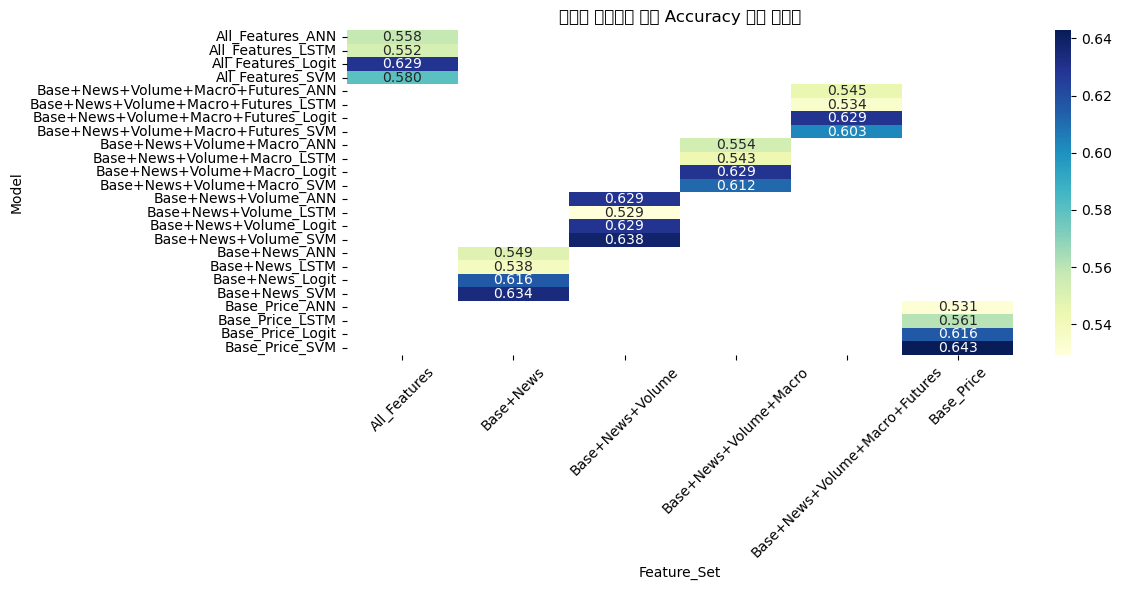

In [13]:

# 5. 결과 분석 및 시각화
print("\n[5단계] 최종 결과 분석")

if all_results:
    results_df = pd.DataFrame(all_results)
    
    # 피쳐셋별 최고 성능
    print("\n=== 피쳐셋별 최고 성능 ===")
    best_by_set = results_df.groupby('Feature_Set')['Accuracy'].max().sort_values(ascending=False)
    print(best_by_set)
    
    # 전체 최고 성능 모델들
    print("\n=== 전체 상위 10개 모델 ===")
    top_models = results_df.nlargest(10, 'Accuracy')[['Model', 'Feature_Set', 'Accuracy', 'F1', 'AUC']]
    print(top_models)
    
    # 성능 개선 분석
    print("\n=== 성능 개선 분석 ===")
    baseline_acc = results_df[results_df['Feature_Set'] == 'Base_Price']['Accuracy'].max()

    print("\n=== 성능 개선 분석 (Accuracy 기준 향상 %) ===")
    for set_name in ['Base+News', 'Base+News+Volume', 'Base+News+Volume+Macro', 
                     'Base+News+Volume+Macro+Futures', 'All_Features']:
        subset = results_df[results_df['Feature_Set'] == set_name]
        if not subset.empty:
            current_acc = subset['Accuracy'].max()
            improvement = (current_acc - baseline_acc) * 100
            print(f"{set_name}: {current_acc:.4f} (↑ {improvement:.2f}%)")
        else:
            print(f"{set_name}: 데이터 없음")

    # 시각화: 피쳐셋별 평균 성능
    print("\n=== 피쳐셋별 모델 평균 성능 (Accuracy 기준) ===")
    avg_accuracy = results_df.groupby('Feature_Set')['Accuracy'].mean().sort_values(ascending=False)
    print(avg_accuracy)

    # 성능 히트맵 시각화
    try:
        pivot_df = results_df.pivot_table(index='Model', columns='Feature_Set', values='Accuracy')
        plt.figure(figsize=(12, 6))
        sns.heatmap(pivot_df, annot=True, fmt=".3f", cmap="YlGnBu")
        plt.title("모델별 피쳐셋에 따른 Accuracy 비교 히트맵")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"히트맵 시각화 실패: {e}")
